In [1]:
%pylab inline
import os
import caffe

Populating the interactive namespace from numpy and matplotlib


In [2]:
netd = os.path.expanduser('~/Documents/nets/deepsim/conv4/generator_no_batch.prototxt')
netw = os.path.expanduser('~/Documents/nets/deepsim/conv4/generator.caffemodel')
net = caffe.Net(netd, caffe.TEST, weights=netw)

In [3]:
print('caffe layers and parameters')
for k, v in net.params.items():
    print(k, f'{str(v[0].data.shape):>20}', f'{str(v[1].data.shape):>8}',
          'bias mean', f'{np.abs(v[1].data).mean():.3f}', sep='\t')

caffe layers and parameters
Rconv6	    (384, 384, 3, 3)	  (384,)	bias mean	0.438
Rconv7	    (512, 384, 3, 3)	  (512,)	bias mean	0.302
Rconv8	    (512, 512, 2, 2)	  (512,)	bias mean	0.228
deconv5	    (512, 256, 4, 4)	  (256,)	bias mean	0.000
conv5_1	    (256, 256, 3, 3)	  (256,)	bias mean	0.000
deconv4	    (256, 128, 4, 4)	  (128,)	bias mean	0.000
conv4_1	    (128, 128, 3, 3)	  (128,)	bias mean	0.000
deconv3	    (128, 128, 4, 4)	  (128,)	bias mean	0.000
conv3_1	    (128, 128, 3, 3)	  (128,)	bias mean	0.000
deconv2	     (128, 64, 4, 4)	   (64,)	bias mean	0.000
conv2_1	      (32, 64, 3, 3)	   (32,)	bias mean	0.000
deconv1	      (32, 16, 4, 4)	   (16,)	bias mean	0.000
conv1_1	       (3, 16, 3, 3)	    (3,)	bias mean	0.000


In [4]:
import torch
from torch import nn

class DeePSiMConv4(nn.Module):
    def __init__(self):
        super().__init__()
        # reusable activation funcs
        self.lrelu = nn.LeakyReLU(negative_slope=0.3)
        self.tanh = nn.Tanh()
        
        # layers
        self.conv6 = nn.Conv2d(384, 384, 3, padding=0)
        self.conv7 = nn.Conv2d(384, 512, 3, padding=0)
        self.conv8 = nn.Conv2d(512, 512, 2, padding=0)
        self.tconv5_0 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)
        self.tconv5_1 = nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1, bias=False)
        self.tconv4_0 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.tconv4_1 = nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1, bias=False)
        self.tconv3_0 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False)
        self.tconv3_1 = nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1, bias=False)
        self.tconv2_0 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
        self.conv2_1 = nn.Conv2d(64, 32, 3, stride=1, padding=1, bias=False)
        self.tconv1_0 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1, bias=False)
        self.conv1_1 = nn.Conv2d(16, 3, 3, stride=1, padding=1, bias=False)
        
    def forward(self, x):
        lrelu = self.lrelu
        x = lrelu(self.conv6(x))
        x = lrelu(self.conv7(x))
        x = lrelu(self.conv8(x))
        x = lrelu(self.tconv5_0(x))
        x = lrelu(self.tconv5_1(x))
        x = lrelu(self.tconv4_0(x))
        x = lrelu(self.tconv4_1(x))
        x = lrelu(self.tconv3_0(x))
        x = lrelu(self.tconv3_1(x))
        x = lrelu(self.tconv2_0(x))
        x = lrelu(self.conv2_1(x))
        x = lrelu(self.tconv1_0(x))
        x = self.tanh(self.conv1_1(x))
        return x * 255

In [5]:
torch_net = DeePSiMConv4()
for n, p in torch_net.named_parameters():
    print(f'{n:<20}', f'{str(tuple(p.shape)):>20}', sep='\t')

conv6.weight        	    (384, 384, 3, 3)
conv6.bias          	              (384,)
conv7.weight        	    (512, 384, 3, 3)
conv7.bias          	              (512,)
conv8.weight        	    (512, 512, 2, 2)
conv8.bias          	              (512,)
tconv5_0.weight     	    (512, 256, 4, 4)
tconv5_1.weight     	    (256, 256, 3, 3)
tconv4_0.weight     	    (256, 128, 4, 4)
tconv4_1.weight     	    (128, 128, 3, 3)
tconv3_0.weight     	    (128, 128, 4, 4)
tconv3_1.weight     	    (128, 128, 3, 3)
tconv2_0.weight     	     (128, 64, 4, 4)
conv2_1.weight      	      (32, 64, 3, 3)
tconv1_0.weight     	      (32, 16, 4, 4)
conv1_1.weight      	       (3, 16, 3, 3)


In [6]:
tshapes = [tuple(p.shape) for p in torch_net.parameters()]

cshapes = []
for k, v in net.params.items():
    cshapes.append(v[0].data.shape)
    if 'Rconv' in k or 'conv' not in k:
        cshapes.append(v[1].data.shape)
len(cshapes), sorted(cshapes)

print('collection of torch and caffe param shapes agree?')
print(tuple(sorted(tshapes)) == tuple(sorted(cshapes)))

collection of torch and caffe param shapes agree?
True


In [7]:
def transfer_params(caffe_net, torch_net, verbose=True):
    if verbose:
        print('caffe parameter name : torch parameter name')
    for n, p in torch_net.named_parameters():
        n1, n2 = n.split('.')
        wb_idx = 1 if n2 == 'bias' else 0
        if n1[-2:] == '_1':
            caffe_n = n1.replace('tconv', 'conv')
        elif n1.find('tconv') == 0:
            if n1[-2] == '_':
                n1 = n1[:-2]
            caffe_n = n1.replace('tconv', 'deconv')
        else:
            caffe_n = n1.replace('conv', 'Rconv')
        if verbose:
            print(f"{caffe_n+'.'+('weight', 'bias')[wb_idx]:<20}", ':', f'{n:<20}', sep='\t')
        p.data = torch.Tensor(caffe_net.params[caffe_n][wb_idx].data)

In [8]:
transfer_params(net, torch_net)

caffe parameter name : torch parameter name
Rconv6.weight       	:	conv6.weight        
Rconv6.bias         	:	conv6.bias          
Rconv7.weight       	:	conv7.weight        
Rconv7.bias         	:	conv7.bias          
Rconv8.weight       	:	conv8.weight        
Rconv8.bias         	:	conv8.bias          
deconv5.weight      	:	tconv5_0.weight     
conv5_1.weight      	:	tconv5_1.weight     
deconv4.weight      	:	tconv4_0.weight     
conv4_1.weight      	:	tconv4_1.weight     
deconv3.weight      	:	tconv3_0.weight     
conv3_1.weight      	:	tconv3_1.weight     
deconv2.weight      	:	tconv2_0.weight     
conv2_1.weight      	:	conv2_1.weight      
deconv1.weight      	:	tconv1_0.weight     
conv1_1.weight      	:	conv1_1.weight      


In [9]:
torch_net.to(device='cuda');

In [10]:
code = np.random.normal(0, 30, size=(1,384,13,13)).astype(np.float32)

In [11]:
tim = torch_net.forward(torch.tensor(code, device='cuda'))
tim = tim.detach().cpu().numpy()

cim = net.forward(feat=code)['generated']

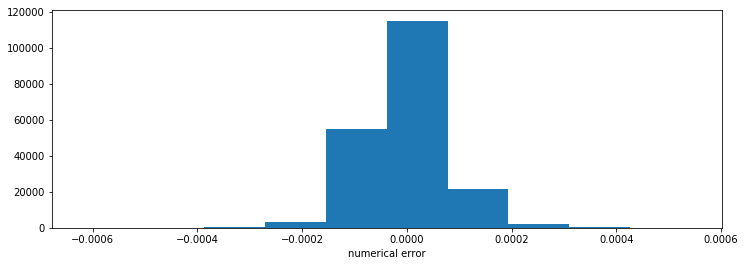

In [12]:
figure(figsize=(12,4))
hist((tim-cim).flatten(), density=False)
xlabel('numerical error');

In [13]:
inet_mean = np.array((104.0, 117.0, 123.0))    # BGR

def deprocess(im):
    im = np.rollaxis(im, -3, len(im.shape))
    im += inet_mean
    im = im[..., ::-1]
    return np.clip(im, 0, 255).astype(np.uint8)

Text(0.5, 1.0, 'pytorch')

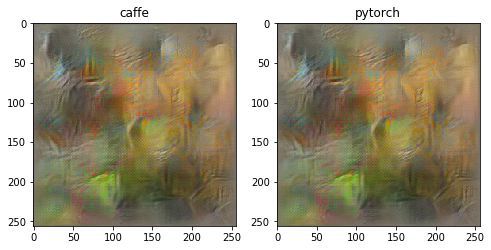

In [14]:
fig, axs = subplots(1, 2, figsize=(8,4))
axs[0].imshow(deprocess(cim)[0])
axs[0].set_title('caffe')
axs[1].imshow(deprocess(tim)[0])
axs[1].set_title('pytorch')

In [15]:
torch.save(torch_net.state_dict(), os.path.expanduser('~/Documents/nets/pytorch/deepsim/conv4.pt'))